In [240]:
import os
os.chdir('/workspace/FutureGPT2/src/')

import numpy as np
from torch import optim, nn, Tensor
from torch.nn import functional as F
import torch
import wandb
from transformers import GPT2Config, GPT2Model
import transformers
import lightning as L
from inspect import signature, _ParameterKind
import copy
import gc
import datasets
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import WandbLogger
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from itertools import repeat, product
from matplotlib import pyplot as plt
import matplotlib

from models.regression_model import *
from data.synthetic import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [241]:
fixed_data_params = {
    'seq_len': 64,
}
free_data_params = {
    'conv': 10,
    'shift': 1,
    'p': 0.3,
}
data_params = {**fixed_data_params, **free_data_params}

In [275]:
ckpts = [
    '/workspace/checkpoints/SYNTH-GPT2-FIN_conv-10_shift-1_p-0.001_lr-0.001_n_embd-128_n_head-2_n_layer-2_activation_function-relu_global_step=58593.0_train_loss=0.00.ckpt',
    '/workspace/checkpoints/SYNTH-GPT2-FIN_conv-10_shift-1_p-0.01_lr-0.001_n_embd-128_n_head-2_n_layer-2_activation_function-relu_global_step=58593.0_train_loss=0.00.ckpt',
    '/workspace/checkpoints/SYNTH-GPT2-FIN_conv-10_shift-1_p-0.1_lr-0.001_n_embd-128_n_head-2_n_layer-2_activation_function-relu_global_step=58593.0_train_loss=0.00.ckpt',
    '/workspace/checkpoints/SYNTH-GPT2-FIN_conv-10_shift-1_p-0.3_lr-0.001_n_embd-128_n_head-2_n_layer-2_activation_function-relu_global_step=58593.0_train_loss=0.00.ckpt',
    '/workspace/checkpoints/SYNTH-GPT2-FIN_conv-10_shift-1_p-1_lr-0.001_n_embd-128_n_head-2_n_layer-2_activation_function-relu_global_step=58593.0_train_loss=0.01.ckpt',
    '/workspace/checkpoints/SYNTH-GPT2-COS_conv-10_shift-1_p-0.3_lr-0.001_n_embd-16_n_head-1_n_layer-2_activation_function-relu_global_step=58593.0_train_loss=0.12.ckpt'
]

In [243]:
myopic_ckpts = [
    '/workspace/checkpoints/SYNTH-GPT2-MYOPIC-COS_BETA0_conv-10_shift-1_p-1_lr-0.001_n_embd-128_n_head-2_n_layer-3_activation_function-relu_global_step=58593.0_train_loss=1.24.ckpt',
    '/workspace/checkpoints/SYNTH-GPT2-MYOPIC-COS_BETA0.0_conv-10_shift-1_p-0.3_lr-0.001_n_embd-128_n_head-2_n_layer-2_activation_function-relu_global_step=58593.0_train_loss=0.32.ckpt',
    '/workspace/checkpoints/SYNTH-GPT2-MYOPIC-COS_BETA0.0_conv-10_shift-1_p-0.1_lr-0.001_n_embd-128_n_head-2_n_layer-2_activation_function-relu_global_step=58593.0_train_loss=0.10.ckpt',
    '/workspace/checkpoints/SYNTH-GPT2-MYOPIC-COS_BETA0.0_conv-10_shift-1_p-0.01_lr-0.001_n_embd-128_n_head-2_n_layer-2_activation_function-relu_global_step=58593.0_train_loss=0.01.ckpt',
]
ckpts = myopic_ckpts

In [276]:
ds = DataLoader(
    SyntheticSeqDataset(size=50_00, **data_params), 
    batch_size=512, 
    #num_workers=20,
    drop_last=True,
)

In [277]:
torch.set_grad_enabled(False)

In [278]:
def f(x, a=10):
    return torch.sin(a*x)

In [285]:
def h(model, lb=20, dim=128):
    l = len(model.model.h)
    for batch in tqdm(iter(ds)):
        x = batch['x'].to('cuda')
        out = model.model(
            inputs_embeds=model.model.wte(x),
            position_ids=torch.arange(0, x.shape[-2], 1, device=x.device),
            output_hidden_states=True,
        )
        out = torch.stack(out['hidden_states'], dim=0).broadcast_to([(lb+1)*2, l+1, 512, 64, dim])
        for i, j in product(range(512), range(64)):
            yield out[:,:,i,j,:]

def z(model, lb=20, dim=128):
    l = len(model.model.h)
    for batch in tqdm(iter(ds)):
        x = batch['x'][:,:,:1].to('cuda').broadcast_to([l+1, 512, 64, dim])
        z = f(x)
        out = []
        out.append(x)
        for i in range(lb):
            x = x.roll(1, dims=2)
            x[:,:,0,:] = 0
            out.append(x)
        out.append(z)
        for i in range(lb):
            z = z.roll(1, dims=2)
            z[:,:,0,:] = 0
            out.append(z)
        out = torch.stack(out, dim=0)
        for i, j in product(range(512), range(64)):
            yield out[:,:,i,j,:]

In [286]:
def covar(x_iter, y_iter=repeat(None)):
    '''
    numerically stable online co/variance
    '''
    meanx = meany = C = n = 0
    for x, y in zip(x_iter, y_iter):
        if y is None:
            y = x
        #y = y.broadcast_to(x.shape)
        n += 1
        dx = x - meanx
        meanx += dx / n
        meany += (y - meany) / n
        C += dx * (y - meany)

    return C / n

In [291]:
def get_cor(model, dim=128):
    hh = covar(h(model, dim=dim))
    hz = covar(h(model, dim=dim), z(model, dim=dim))
    zz = covar(z(model, dim=dim))
    cor = hz / torch.sqrt(hh * zz)
    cor = cor.cpu().numpy()
    return cor

In [292]:
def plot_cor(cor, name=''):
    n = cor.shape[0] // 2
    l = len(model.model.h)
    plt.figure(figsize=(7, 10))
    imshow_params = {
        'aspect': 'auto', 
        'vmin': 0., 
        'vmax': 0.5, 
        'interpolation': 'none',
        'cmap': 'BuPu',
    }
    titlesize = 16
    ticksize = 14
    for i in range(l+1):
        #print(i)
        plt.subplot(3, 2, 2*i+1, aspect='auto')
        plt.imshow((np.abs(cor)**0.5)[:n,i,:], **imshow_params)
        plt.title(f'$\\rho$(layer {i}, $x_{{n-i}}$)', fontsize=titlesize)
        plt.xlabel('neuron index', fontsize=titlesize)
        plt.ylabel('lookback index $i$', fontsize=titlesize)
        plt.xticks(fontsize=ticksize)
        plt.yticks(fontsize=ticksize)
        plt.subplot(3, 2, 2*i+2, aspect='auto')
        plt.imshow((np.abs(cor)**0.5)[n:,i,:], **imshow_params)
        plt.title(f'$\\rho$(layer {i}, $\sin(10x_{{n-i}}))$', fontsize=titlesize)
        plt.xlabel('neuron index', fontsize=titlesize)
        plt.xticks(fontsize=ticksize)
        plt.yticks(fontsize=ticksize)
        #plt.ylabel('index $i$')
    plt.tight_layout(pad=1.0)
    #cbar = plt.colorbar(pad=0.05)
    #ticks = np.linspace(0, 1, num=5)
    #cbar.set_ticks(ticks)
    #cbar.set_ticklabels([f'{val**3:.2f}' for val in ticks])
    plt.savefig(f'/workspace/FutureGPT2/src/scripts/synth_neuron_r2{name}.png')
    plt.show()

In [289]:
model = LitGPT2RegModel.load_from_checkpoint(ckpts[-1])

In [293]:
cor = get_cor(model, dim=16)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [236]:
cor = np.load('/workspace/data/syth_neuron_r2_p0.3_myopic.npy')

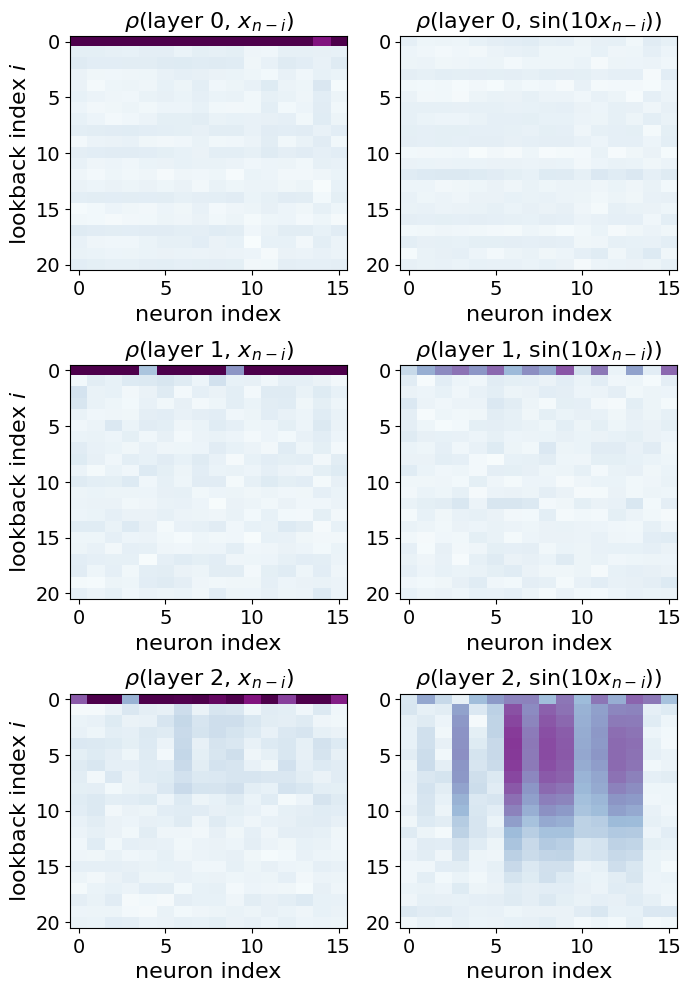

In [294]:
plot_cor(cor, '_myopic')

In [244]:
def get_r2(ckpt, layer, lb=20, f=lambda x: torch.sin(10*x), by_pos=False, get_W=False):
    ZZ, HH, HZ = 0, 0, 0
    model = LitGPT2RegModel.load_from_checkpoint(ckpt)
    for batch in tqdm(iter(ds)):
        x = batch['x'].to('cuda')
        out = model.model(
            inputs_embeds=model.model.wte(x),
            position_ids=torch.arange(0, x.shape[-2], 1, device=x.device),
            output_hidden_states=True,
        )
        H = out['hidden_states'][layer]
        # add bias
        H = torch.concat([H, torch.ones(H.shape[:-1] + (1,), device=H.device)], dim=-1)
        
        x = x[...,0]
        Z = []
        Z.append(f(x))
        for i in range(lb):
            x = x.roll(1, dims=1)
            x[:,0,] = 0
            Z.append(f(x))
        Z = torch.stack(Z, dim=2)
        
        H = H.cpu().numpy().astype(np.float64)
        Z = Z.cpu().numpy().astype(np.float64)
        
        if not by_pos:
            # flatten out batch_dim x seq_dim
            H = H.reshape((-1, H.shape[-1]))
            Z = Z.reshape((-1, Z.shape[-1]))
            ZZ = Z.T @ Z
            HH = H.T @ H
            HZ = H.T @ Z
        else:
            # move seq dim to front to do per-position R^2
            H = H.transpose((1, 0, 2))
            Z = Z.transpose((1, 0, 2))
            
            ZZ = Z.transpose((0, 2, 1)) @ Z
            HH = H.transpose((0, 2, 1)) @ H
            HZ = H.transpose((0, 2, 1)) @ Z
    HZT = HZ.transpose(0, 2, 1) if by_pos else HZ.T
    num = (HZT @ np.linalg.inv(HH + 1e-4 * np.eye(129)) @ HZ)#.diagonal(axis1=1, axis2=2)
    denom = ZZ
    if not get_W:
        return num / denom
    else:
        return np.linalg.inv(HH + 1e-4 * np.eye(129)) @ HZ

In [24]:
ckpts

['/workspace/checkpoints/SYNTH-GPT2-MYOPIC-COS_BETA0_conv-10_shift-1_p-1_lr-0.001_n_embd-128_n_head-2_n_layer-3_activation_function-relu_global_step=58593.0_train_loss=1.24.ckpt',
 '/workspace/checkpoints/SYNTH-GPT2-MYOPIC-COS_BETA0.0_conv-10_shift-1_p-0.3_lr-0.001_n_embd-128_n_head-2_n_layer-2_activation_function-relu_global_step=58593.0_train_loss=0.32.ckpt',
 '/workspace/checkpoints/SYNTH-GPT2-MYOPIC-COS_BETA0.0_conv-10_shift-1_p-0.1_lr-0.001_n_embd-128_n_head-2_n_layer-2_activation_function-relu_global_step=58593.0_train_loss=0.10.ckpt']

In [263]:
ds = DataLoader(
    SyntheticSeqDataset(size=50_00, **{**data_params, 'p':0.3}), 
    batch_size=512, 
    #num_workers=20,
    drop_last=True,
)

In [ ]:
r2_d = {}
for ckpt in ckpts:
    print(ckpt)
    r2_l = []
    for layer in range(3):
        print('LAYER', layer)
        r2 = get_r2(ckpt, layer).diagonal()
        #plt.plot(r2)
        print(r2)
        r2_l.append(r2)
    #plt.show()
    r2_d[ckpt] = r2_l

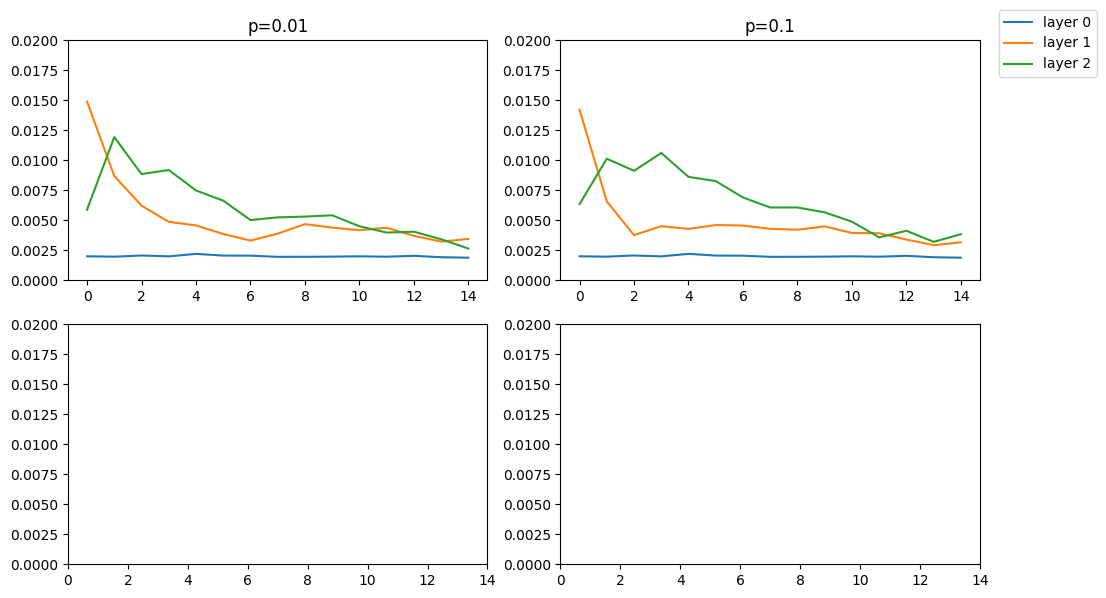

In [89]:
idxs = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0)]
ps = [0.001, 0.01, 0.1, 0.3, 1]
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
lines =  []
for k, p, idx in list(zip(ckpts[1:], ps[1:], idxs[:-1])):
    for l in range(3):
        lines.append(axs[idx].plot(r2_d[k][l][:15], label=f'layer {l}'))
    axs[idx].set_title(f'p={p}')
#axs[(2, 1)].axis('off')
labels = [line[0].get_label() for line in lines[:3]]
handles = [line[0] for line in lines[:3]]
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 1.0))
for ax in axs.flat:
    ax.set_xticks(range(0, 15, 2))
    ax.set_ylim(0, 0.02) 
plt.tight_layout()
#plt.suptitle('$R^2$ between hidden state and $\sin(10x_{n-i}$)', y=1.02)
#plt.savefig('/workspace/FutureGPT2/src/scripts/synth_r2.png')
plt.show()

In [ ]:
r2 = get_r2('/workspace/checkpoints/SYNTH-GPT2-MYOPIC-COS_conv-10_shift-0_p-1_lr-0.001_n_embd-128_n_head-2_n_layer-2_activation_function-relu_global_step=58593.0_train_loss=0.10.ckpt', 2)

In [ ]:
plt.plot(r2.diagonal())

In [264]:
W = get_r2(myopic_ckpts[1], 1, get_W=True)[:,[0]]

  0%|          | 0/9 [00:00<?, ?it/s]

In [248]:
model = LitGPT2RegModel.load_from_checkpoint(ckpt)

In [265]:
from itertools import islice
x = torch.concat([b['x'] for b in islice(iter(ds), 10)][:1], dim=0).to('cuda')
out = model.model(
    inputs_embeds=model.model.wte(x),
    position_ids=torch.arange(0, x.shape[-2], 1, device=x.device),
    output_hidden_states=True,
)
H = out.hidden_states

In [266]:
H = H[1].flatten(end_dim=1)
H = torch.concat([H, torch.ones((H.shape[0], 1), device=H.device)], dim=1)

In [267]:
yhat = H.cpu().numpy() @ W

/tmp/ipykernel_22450/446686375.py:5: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


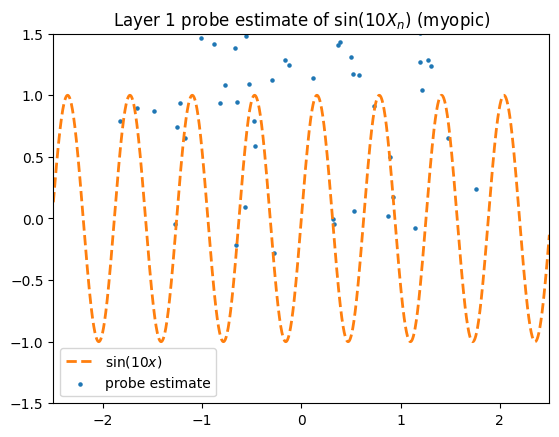

In [274]:
a = np.arange(-3, 3, 0.0001)
plt.plot(a, np.sin(10 * a), color='tab:orange', linewidth=2, label='$\sin(10x)$', alpha=1, linestyle='dashed')
plt.scatter(x[:,:,0].flatten().cpu().numpy()[:300], yhat.flatten()[:300], alpha=1, label='probe estimate', s=5)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlim(-2.5, 2.5)
plt.ylim(-1.5, 1.5)
plt.title('Layer 1 probe estimate of $\sin(10X_n)$ (myopic)')
plt.savefig('/workspace/FutureGPT2/src/scripts/synth_sine_myopic.png')
plt.show()

In [ ]:
model.loss_fn = nn.HuberLoss()

In [178]:
for k, p in zip(ckpts, [1, 0.3, 0.1, 0.01]):
    data_params['p'] = p
    ds = DataLoader(
        SyntheticSeqDataset(size=50_000, **data_params), 
        batch_size=512, 
        #num_workers=20,
        drop_last=True,
    )
    model = LitGPT2RegModel.load_from_checkpoint(k)
    loss = 0
    total = 0
    for batch in tqdm(iter(ds)):
        loss += model.loss(
            {'x': batch['x'].to('cuda'), 'y': batch['y'].to('cuda')}
        )
        total += 1
    print(k)
    print((loss / total).item())
    print((loss / total).item() / p)

  0%|          | 0/97 [00:00<?, ?it/s]

/workspace/checkpoints/SYNTH-GPT2-MYOPIC-COS_BETA0_conv-10_shift-1_p-1_lr-0.001_n_embd-128_n_head-2_n_layer-3_activation_function-relu_global_step=58593.0_train_loss=1.24.ckpt
1.2569974660873413
1.2569974660873413


  0%|          | 0/97 [00:00<?, ?it/s]

/workspace/checkpoints/SYNTH-GPT2-MYOPIC-COS_BETA0.0_conv-10_shift-1_p-0.3_lr-0.001_n_embd-128_n_head-2_n_layer-2_activation_function-relu_global_step=58593.0_train_loss=0.32.ckpt
0.3102075159549713
1.0340250531832378


  0%|          | 0/97 [00:00<?, ?it/s]

/workspace/checkpoints/SYNTH-GPT2-MYOPIC-COS_BETA0.0_conv-10_shift-1_p-0.1_lr-0.001_n_embd-128_n_head-2_n_layer-2_activation_function-relu_global_step=58593.0_train_loss=0.10.ckpt
0.09659672528505325
0.9659672528505325


  0%|          | 0/97 [00:00<?, ?it/s]

/workspace/checkpoints/SYNTH-GPT2-MYOPIC-COS_BETA0.0_conv-10_shift-1_p-0.01_lr-0.001_n_embd-128_n_head-2_n_layer-2_activation_function-relu_global_step=58593.0_train_loss=0.01.ckpt
0.01102979015558958
1.102979015558958


In [ ]:
model.loss?

In [52]:
ds = DataLoader(
    SyntheticSeqDataset(size=50_00, **{**data_params, 'p':0.1}), 
    batch_size=512, 
    #num_workers=20,
    drop_last=True,
)

In [53]:
batch = next(iter(ds))

In [54]:
model = LitGPT2RegModel.load_from_checkpoint(ckpts[-1])

In [55]:
out = model({'x': batch['x'].to('cuda')})

In [56]:
nn.HuberLoss()(out, batch['y'].to('cuda'))

tensor(0.0974, device='cuda:0')

In [64]:
r = torch.concat([batch['x'][0], out[0].to('cpu'), batch['y'][0]], dim=1)
r1 = r[r[:,1] > 0.5]
r0 = r[r[:,0] < 0.5]

In [66]:
nn.HuberLoss()(r1[:,2], r1[:,3])

tensor(1.2713)

In [68]:
r1.shape[0] / r.shape[0]

0.078125

In [76]:
nn.HuberLoss()(out.to('cpu')[batch['x'][:,:,[1]] > 0.5], batch['y'][batch['x'][:,:,[1]] > 0.5])

tensor(0.9744)

In [79]:
batch['y'][batch['x'][:,:,[1]] > 0.5].shape

torch.Size([3275])

In [80]:
nn.HuberLoss()(torch.zeros(3275), batch['y'][batch['x'][:,:,[1]] > 0.5])

tensor(1.2833)

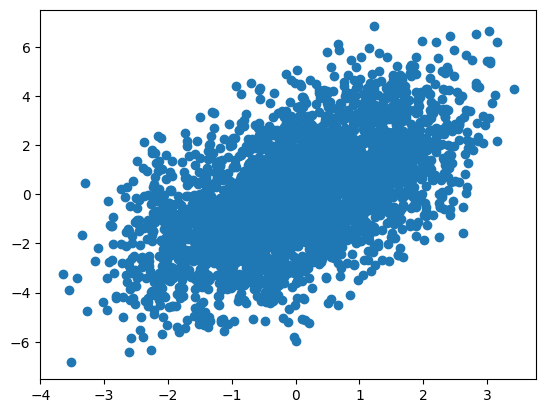

In [82]:
plt.scatter(
    out.to('cpu')[batch['x'][:,:,[1]] > 0.5].numpy(), 
    batch['y'][batch['x'][:,:,[1]] > 0.5].numpy()
)